In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Compile the Linux kernel

3 MDSs, 9 OSDs, 1 client

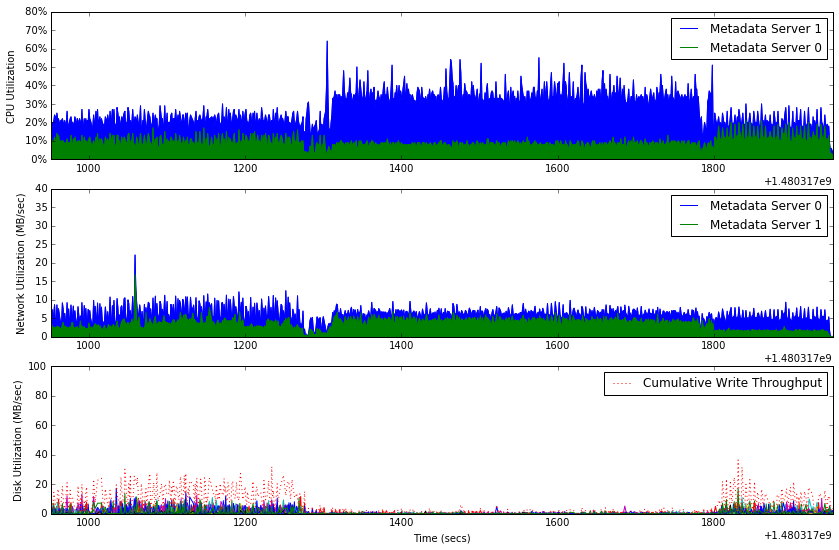

In [4]:
fig, myax = plt.subplots(3, 1, figsize=(14, 9))
ax = myax[0]

s = 'compile/results/'
init = 0
mdss = ["12", "15"]

####################### CPU #######################
count = 0
prev = pd.DataFrame(columns=["index", "time", "user"])
for m in mdss:
    df = pd.read_csv(s + 'user.wsp-issdm-'+m+'.out', skiprows=13, names=["index", "time",'user'])
    df = df[df['time'] != 0]                  # filter out null timestamps
    if init == 0:
        init = float(df['time'].loc[0])       # beginning of runs shifted to 0 (unix time stamp)
    else:
        shift = df['time'].loc[0] - init      # get delay of this run compared to initial run
        df['index'] = df['index'] + shift     # shift this run by the delay 
        t = int(df['index'].tail(1))          # get the last entry in this run
        for i in range(0, int(shift+1)):      # start appending bogus values to this df
            df.loc[t+1+i] = [i, i + init, 0] 
        new = pd.merge(prev, df, on='index')  # now that indices line up, merge 'em
    prev = df                                 # save for the next iteration        
    count = count + 1

# calculate the cumulative values and graph
new['cum'] = new['user_x'] + new['user_y']
new.plot(ax=ax, x='time_x', y='cum', label='Metadata Server 1')
ax.fill_between(new['time_x'], 0, new['cum'], color='blue')
new.plot(ax=ax, x='time_x', y='user_x', label='Metadata Server 0')
ax.fill_between(new['time_x'], 0, new['user_x'], color='green')

# make the graph pretty
ax.set_xlabel("")
ax.set_ylabel("CPU Utilization")
vals = ax.get_yticks()
x = ax.set_yticklabels(['{:3.0f}%'.format(x*1) for x in vals])

####################### Network #######################
ax = myax[1]
init = 0
mdss = ["15", "12"]

count = 0
new = pd.DataFrame(columns=["index", "time", "kbin"])
mynew = pd.DataFrame(columns=["index", "time", "kbin"])
prev = pd.DataFrame(columns=["index", "time", "kbin"])
for m in mdss:
    df = pd.read_csv(s + 'kbin.wsp-issdm-'+m+'.out', skiprows=13, names=["index", "time",'kbin'])
    df = df[df['time'] != 0]                  # filter out null timestamps
    
    df1 = pd.read_csv(s + 'kbout.wsp-issdm-'+m+'.out', skiprows=13, names=["index", "time",'kbout'])
    df1 = df1[df1['time'] != 0]               # filter out null timestamps
    
    if init == 0:
        init = float(df['time'].loc[0])       # beginning of runs shifted to 0 (unix time stamp)
        shift = df1['time'].loc[0] - init
        t = int(df1['index'].tail(1))         # get the last entry in this run
        for i in range(0, int(shift+1)):      # start appending bogus values to this df
            df1.loc[t+1+i] = [i, i + init, 0]                    
        new = pd.merge(df, df1, on='time')
        del new['index_y']
        new.columns = ['index', 'time', 'kbin', 'kbout']
    else:
        shift = df['time'].loc[0] - init      # get delay of this run compared to initial run
        df['index'] = df['index'] + shift     # shift this run by the delay 
        t = int(df['index'].tail(1))          # get the last entry in this run
        for i in range(0, int(shift+1)):      # start appending bogus values to this df
            df.loc[t+1+i] = [i, i + init, 0]

        shift = df1['time'].loc[0] - init     # get delay of this run compared to initial run
        df1['index'] = df1['index'] + shift   # shift this run by the delay 
        t = int(df1['index'].tail(1))         # get the last entry in this run
        for i in range(0, int(shift+1)):      # start appending bogus values to this df
            df1.loc[t+1+i] = [i, i + init, 0]            
        mynew = pd.merge(df, df1, on='time')    
        del mynew['index_y']
        mynew.columns = ['index', 'time', 'kbin', 'kbout']
        
        new = pd.merge(new, mynew, on='time')
        del new['index_y']
    prev = df                                 # save for the next iteration        
    count = count + 1

# calculate the cumulative values and graph
new['issdm-15'] = new['kbin_x'] + new['kbout_x']
new['issdm-12'] = new['kbin_y'] + new['kbout_y'] + new['issdm-15']

new.plot(ax=ax, x='time', y='issdm-12', label='Metadata Server 0')
ax.fill_between(new['time'], 0, new['issdm-12'], color='blue')
new.plot(ax=ax, x='time', y='issdm-15', label='Metadata Server 1')
ax.fill_between(new['time'], 0, new['issdm-15'], color='green')

# maek graph pretty
ax.set_xlabel("")
ax.set_ylabel("Network Utilization (MB/sec)")
vals = ax.get_yticks()
x = ax.set_yticklabels(['{:3.0f}'.format(x/1000) for x in vals])
ax.set_ylim(0, 40000)

####################### Disk #######################
ax = myax[2]
s = 'compile/results/'
init = 0
mdss = ["0", "1", "11", "14", "24", "27", "29", "34", "40"]

count = 0
new = pd.DataFrame(columns=["index", "time", "writekbs"])
prev = pd.DataFrame(columns=["index", "time", "writekbs"])
cols = ['index', 'time', 'writekbs-issdm-0']
for m in mdss:
    df = pd.read_csv(s + 'writekbs.wsp-issdm-'+m+'.out', skiprows=13, names=["index", "time",'writekbs'])
    df = df[df['time'] != 0]                  # filter out null timestamps
    if init == 0:
        init = float(df['time'].loc[0])       # beginning of runs shifted to 0 (unix time stamp)
        new = df
        new.columns = cols
    else:
        shift = df['time'].loc[0] - init      # get delay of this run compared to initial run
        df['index'] = df['index'] + shift     # shift this run by the delay 
        t = int(df['index'].tail(1))          # get the last entry in this run
        for i in range(0, int(shift+1)):      # start appending bogus values to this df
            df.loc[t+1+i] = [i, i + init, 0] 
        new = pd.merge(new, df, on='index')   # now that indices line up, merge 'em
        del new['time_y']
        cols.append('writekbs-issdm-' + str(m))
        new.columns = cols
    new.plot(ax=ax, x='time', y='writekbs-issdm-' + str(m), label='Obj Storage Server ' + str(count))
    prev = df                                 # save for the next iteration        
    count = count + 1
    
# calculate the cumulative values and graph
init = 0
for m in mdss:
    if init == 0:
        new['cum'] = new['writekbs-issdm-' + str(m)]
        init = 1
    else:
        new['cum'] = new['cum'] + new['writekbs-issdm-' + str(m)]
ax.legend().remove()
new.plot(ax=ax, x='time', y='cum', ls='dotted', label='Cumulative Write Throughput')

# make graph pretty
ax.set_xlabel("Time (secs)")
ax.set_ylabel("Disk Utilization (MB/sec)")
vals = ax.get_yticks()
x = ax.set_yticklabels(['{:3.0f}'.format(x/1000) for x in vals])
#ax.set_ylim(0, 40000)


# make the graph pretty
for i in range(0, 3):
    #init=1480317102
    myax[i].set_xlim(1480317952, 1480318952)
    #myax[i].set_xlim(0, 1850)
fig.savefig('paper/graphs/overhead-creates.png', dpi=200)